In [1]:
import tensorflow as tf

import numpy as np
import os
import time

In [2]:
import tensorflow as tf
print(tf.__version__)  # Ensure that we're using "2.0.0-rc1"
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)


2.0.0-rc1


In [3]:
import tensorflow.keras as k
import tensorflow_probability as tfp

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn.metrics as metrics
import pdb
from pdb import set_trace as bp

### Note: 
This notebook builds on [this tensorflow tutorial](https://www.tensorflow.org/tutorials/text/text_generation). 

In [5]:
%ls

models/                             stock_exchange.txt
nyc_stock_exchange.txt              text_response_experiment_0.ipynb
principles_of_plitical_economy.txt  text_response_experiment_RNN_CNN.ipynb
stock_exchange_from_within.txt      VAE_text.ipynb


In [6]:
text = open('principles_of_plitical_economy.txt', 'rb').read().decode(encoding='utf-8')
text += open('stock_exchange.txt', 'rb').read().decode(encoding='utf-8')
text += open('nyc_stock_exchange.txt', 'rb').read().decode(encoding='utf-8')
text += open('stock_exchange_from_within.txt', 'rb').read().decode(encoding='utf-8')
print(text[:250])
print ('Length of text: {} characters'.format(len(text)))

The Project Gutenberg EBook of Principles Of Political Economy by John
Stuart Mill



This eBook is for the use of anyone anywhere at no cost and with almost no
restrictions whatsoever. You may copy it, give it away or re-use it under
the term
Length of text: 2584696 characters


In [7]:
vocab = sorted(set(text))
print ('{} unique characters'.format(len(vocab)))
print(vocab)

138 unique characters
['\n', '\x0c', '\r', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '\xa0', '£', '§', '°', '¼', '½', '¾', 'É', '×', 'à', 'â', 'ä', 'æ', 'ç', 'è', 'é', 'ê', 'ë', 'î', 'ô', 'ö', 'ü', 'Œ', 'ε', 'η', 'ι', 'ρ', 'ς', 'σ', 'τ', 'φ', 'χ', 'ω', 'ά', 'ύ', 'ῆ', '–', '—', '‘', '’', '“', '”', '™', '⅛', '⅜', '\ufeff']


Mapping the strings to a numerical representation

In [8]:
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

In [9]:
text_as_int.shape

(2584696,)

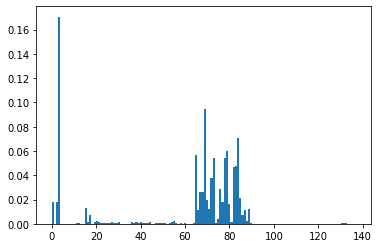

In [10]:
data = plt.hist(text_as_int, bins=len(vocab), density=True)
plt.show()

In [11]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  '\x0c':   1,
  '\r':   2,
  ' ' :   3,
  '!' :   4,
  '"' :   5,
  '#' :   6,
  '$' :   7,
  '%' :   8,
  '&' :   9,
  "'" :  10,
  '(' :  11,
  ')' :  12,
  '*' :  13,
  '+' :  14,
  ',' :  15,
  '-' :  16,
  '.' :  17,
  '/' :  18,
  '0' :  19,
  ...
}


In [12]:
# Show how the first 13 characters from the text are mapped to integers
print ('{} ---- characters mapped to int ---- > {}'.format(repr(text[:13]), text_as_int[:13]))

'The Project G' ---- characters mapped to int ---- > [55 72 69  3 51 82 79 74 69 67 84  3 42]


In [13]:
# The maximum length sentence we want for a single input in characters
seq_length = 256
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
  print(idx2char[i.numpy()])

T
h
e
 
P


In [14]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
  print(repr(''.join(idx2char[item.numpy()])))

'The Project Gutenberg EBook of Principles Of Political Economy by John\r\nStuart Mill\r\n\r\n\r\n\r\nThis eBook is for the use of anyone anywhere at no cost and with almost no\r\nrestrictions whatsoever. You may copy it, give it away or re-use it under\r\nthe terms of th'
'e Project Gutenberg License included with this eBook or\r\nonline at http://www.gutenberg.org/license\r\n\r\n\r\n\r\nTitle: Principles Of Political Economy\r\n\r\nAuthor: John Stuart Mill\r\n\r\nRelease Date: September 27, 2009 [Ebook #30107]\r\n\r\nLanguage: English\r\n\r\nCharacte'
'r set encoding: UTF-8\r\n\r\n\r\n***START OF THE PROJECT GUTENBERG EBOOK PRINCIPLES OF POLITICAL ECONOMY***\r\n\r\n\r\n\r\n\r\n\r\n                     Principles Of Political Economy\r\n\r\n                                    By\r\n\r\n                             John Stuart Mill\r'
'\n\r\n                Abridged, with Critical, Bibliographical,\r\n\r\n                   and Explanatory Notes, and a Sketch\r\n\r\n                   

In [15]:
sequences

<BatchDataset shapes: (257,), types: tf.int64>

In [16]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [17]:
dataset

<MapDataset shapes: ((256,), (256,)), types: (tf.int64, tf.int64)>

In [18]:
for input_example, target_example in  dataset.take(1):
  print ('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
  print ('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Input data:  'The Project Gutenberg EBook of Principles Of Political Economy by John\r\nStuart Mill\r\n\r\n\r\n\r\nThis eBook is for the use of anyone anywhere at no cost and with almost no\r\nrestrictions whatsoever. You may copy it, give it away or re-use it under\r\nthe terms of t'
Target data: 'he Project Gutenberg EBook of Principles Of Political Economy by John\r\nStuart Mill\r\n\r\n\r\n\r\nThis eBook is for the use of anyone anywhere at no cost and with almost no\r\nrestrictions whatsoever. You may copy it, give it away or re-use it under\r\nthe terms of th'


In [19]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step    0
  input: 55 ('T')
  expected output: 72 ('h')
Step    1
  input: 72 ('h')
  expected output: 69 ('e')
Step    2
  input: 69 ('e')
  expected output: 3 (' ')
Step    3
  input: 3 (' ')
  expected output: 51 ('P')
Step    4
  input: 51 ('P')
  expected output: 82 ('r')


In [20]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 100000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((64, 256), (64, 256)), types: (tf.int64, tf.int64)>

# LSTM and CNN Model

The model below is an experiment to verify performance of an LSTM layer, which tries to learn sequential patterns, and a CNN layer, that is trying to learn spatial patterns from covariance matrix of the respective samples computed. The idea is then to combine this information, to attempt to produce a better predictions. 

In [27]:
class LSTMCNNModel(k.Model):
    def __init__(self, 
                 vocab_size, 
                 embedding_dim, 
                 rnn_units, 
                 batch_size):
        super(LSTMCNNModel, self).__init__()
        self.embedding_0 = k.layers.Embedding(vocab_size, 
                                              embedding_dim,
                                              batch_input_shape=[batch_size, None])
        self.rnn_0 = k.layers.LSTM(rnn_units, 
                                  return_sequences=True,
                                  stateful=True,
                                  recurrent_initializer='glorot_uniform')
        self.cnn_0 = k.layers.Conv2D(filters=1, kernel_size=3,
                                    activation='relu', data_format='channels_last')
        self.max_0 = k.layers.MaxPool2D()
        self.flatten = k.layers.Flatten()
        
        self.d_0 = k.layers.Dense(vocab_size, activation=None)
        

    def call(self, x, labels=None):
        bp()
        x = self.embedding_0(x)
        x_lstm = self.rnn_0(x)
        x_cov = tf.reduce_mean(x_lstm, axis=1)
        x_cov_container = tf.zeros([64, 1024, 1024])
        for i in range(x_cov.shape[0]):
            x_cov_container[i, :, :] = tf.matmul(x_cov[i, :], x_cov[i, :], 
                                                transpose_b=True) / tf.reduce_sum(x_cov[i, :])
        x_cov_container = tf.reshape(x_cov_container, np.append(x_cov_container.shape, 1))
        x_cnn = self.cnn_0(x_cov_container)
        x_cnn = self.max_0(x_cnn)
        x_cnn = self.flatten(x_cnn)
        x = tf.concat((x_lstm, x_cnn), axis=0)
        x = self.d_0(x)
        return x


    

In [22]:
def train_step(input_data,
               target_data,
               model,
               optimizer, 
               train_loss_container,):
    with tf.device('gpu'):
        with tf.GradientTape() as tape:
            predictions = model(input_data)
            # bp()
            loss = tf.reduce_mean(
                tf.keras.losses.sparse_categorical_crossentropy(target_data,
                                                                predictions, 
                                                                from_logits=True))
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        train_loss_container.append(loss)
    return loss

In [23]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [24]:
def generate_text(model, start_string, 
                  num_generate=1000):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = num_generate

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    # We must have the same batch size, as we stipulated in the model build. 
    input_data = np.zeros([BATCH_SIZE, len(input_eval)], dtype=np.int32)
    input_data[0] += input_eval
    # Empty string to store our results
    text_generated = []
    
    # Low temperatures results in more predictable text.
    # Higher temperatures results in more surprising text.
    # Experiment to find the best setting.
    temperature = 1.0

    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_data)[0]
        # using a categorical distribution to predict the word returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # We pass the predicted word as the next input to the model
        # along with the previous hidden state
        input_eval = [predicted_id]
        input_data = np.zeros([BATCH_SIZE, len(input_eval)], dtype=np.int32)
        input_data[0] += input_eval

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [25]:
with tf.device('gpu'):
    optimizer = k.optimizers.Adam(learning_rate=0.001, 
                              epsilon=1e-07)
    train_loss_container = []
    model = LSTMCNNModel(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)
    EPOCHS = 5

In [26]:
with tf.device('gpu'):
    # EPOCHS = 10
    for epoch in range(EPOCHS):
        start_time = time.time()
        if epoch > 0:
            hidden = model.reset_states()


        for (batch_number, (input_data, target_data)) in enumerate(dataset):
            loss = train_step(input_data, 
                              target_data, 
                              model, 
                              optimizer,
                              train_loss_container)
            if batch_number % 100 == 0:
                template = 'Epoch {} Batch {} Loss {}'
                print(template.format(epoch+1, batch_number, loss))
        model.save_weights('models/' + model.name + str(EPOCHS) + '_' + str(seq_length))
        print ('Epoch {} Loss {:.4f}'.format(epoch+1, loss))
        print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start_time))
model.save_weights('models/' + model.name + str(EPOCHS) + '_' + str(seq_length))

> <ipython-input-21-fd7f65364055>(25)call()
-> x = self.embedding_0(x)
(Pdb) n
> <ipython-input-21-fd7f65364055>(26)call()
-> x_lstm = self.rnn_0(x)
(Pdb) n
> <ipython-input-21-fd7f65364055>(27)call()
-> x_cov = tf.reduce_mean(x_lstm, axis=1)
(Pdb) n
> <ipython-input-21-fd7f65364055>(28)call()
-> x_cov_container = tf.zeros([64, 1024, 1024])
(Pdb) n
> <ipython-input-21-fd7f65364055>(29)call()
-> for i in range(x_cov.shape[0]):
(Pdb) n
> <ipython-input-21-fd7f65364055>(30)call()
-> x_cov_container[i, :, :] = tfp.stats.covariance(tf.reshape(x_cov[i,:],
(Pdb) n
> <ipython-input-21-fd7f65364055>(31)call()
-> [x_cov[i,:].shape[0],
(Pdb) n
> <ipython-input-21-fd7f65364055>(32)call()
-> 1]),
(Pdb) n
> <ipython-input-21-fd7f65364055>(33)call()
-> sample_axis=0)
(Pdb) n
TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment
> <ipython-input-21-fd7f65364055>(33)call()
-> sample_axis=0)
(Pdb) q


BdbQuit: 

In [ ]:
print(generate_text(model, start_string=u"test", num_generate=150))
